# Attempt Numero Uno

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

from IPython.core.display import display, HTML

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_25/13196397.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
class Config:
    TRAIN_SPLIT = 0.8
    BATCH_SIZE = 64
    NUM_EPOCHS = 30
config = Config()
data_root = '/kaggle/input/chess-bot-version-1-ratings'
model_path = '/kaggle/working/checkpoint'

In [3]:
boards = []
sides = []
ratings = []
ratings_root = f'{data_root}/v1'

for name in os.listdir(ratings_root):
    with open(f'{ratings_root}/{name}', 'rt') as txt:
        for ind, i in enumerate(txt.readlines()):
            nums = i.split()
            assert len(nums) == 65
            boards.append([int(val) for val in nums[:64]])
            sides.append(0 if ind % 2 == 0 else 1)
            ratings.append(float(nums[64]))

In [4]:
boards_raw = np.asarray(boards).astype('int32')
sides_raw = np.asarray(sides).astype('int32')
predict_raw = np.asarray(ratings).astype('int32')

## Define Model

In [5]:
board_input = keras.Input((64,13), name='board')
side_input = keras.Input((1,), name='side')
flattened_input = layers.Flatten()(board_input)
model_input = layers.concatenate((flattened_input, side_input))
x = layers.Dense(512, activation='relu')(model_input)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
out = layers.Dense(1)(x)

In [6]:
model = keras.Model(inputs=(board_input, side_input), outputs=out, name='chess-test-1')

In [7]:
model.summary()

Model: "chess-test-1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 64, 13)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 832)                  0         ['board[0][0]']               
                                                                                                  
 side (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 833)                  0         ['flatten[0][0]',             
                                                                     'side[0][0]']     

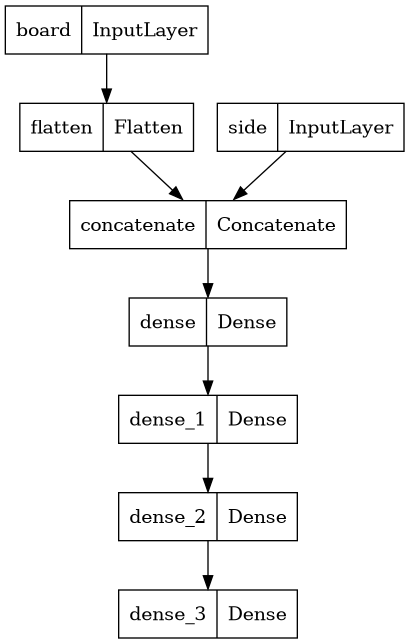

In [8]:
keras.utils.plot_model(model)

## Train Model

In [9]:
x1_data, x2_data, y_data = boards_raw[abs(predict_raw) < 8000].copy(), sides_raw[abs(predict_raw) < 8000].copy(), predict_raw[abs(predict_raw) < 8000].copy()
index = np.asarray(range(len(x2_data)))
np.random.shuffle(index)
x1_data = x1_data[index]
x2_data = x2_data[index]
y_data = y_data[index]

y_mean = y_data.mean()
y_std = y_data.std()
y_data = (y_data - y_mean) / y_std

x1_data = tf.one_hot(x1_data, depth=13, axis=-1)

In [10]:
split_val = int(len(x1_data) * config.TRAIN_SPLIT)
(train_x1, train_x2, train_y), (test_x1, test_x2, test_y) = (x1_data[:split_val], x2_data[:split_val], y_data[:split_val]), (x1_data[split_val:], x2_data[split_val:], y_data[split_val:])

In [11]:
history = []
best_val_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=False,
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True
)

def run_train_iteration(rate):
    print(f"Training with rate {rate}")
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.RMSprop(learning_rate=rate, momentum=0.5),
        metrics=[keras.metrics.MeanAbsoluteError()]
    )
    history.append(model.fit({
        'board': train_x1,
        'side': train_x2,
    }, train_y, batch_size=config.BATCH_SIZE, epochs=config.NUM_EPOCHS, validation_split=0.2, callbacks=[best_val_callback]))

run_train_iteration(0.001)

Training with rate 0.001
Epoch 1/30
1962/1962 [==============================] - 11s 4ms/step - loss: 0.2547 - mean_absolute_error: 0.3583 - val_loss: 0.1298 - val_mean_absolute_error: 0.2540
Epoch 2/30
1962/1962 [==============================] - 7s 3ms/step - loss: 0.1255 - mean_absolute_error: 0.2567 - val_loss: 0.1111 - val_mean_absolute_error: 0.2323
Epoch 3/30
1962/1962 [==============================] - 6s 3ms/step - loss: 0.1058 - mean_absolute_error: 0.2335 - val_loss: 0.1211 - val_mean_absolute_error: 0.2558
Epoch 4/30
1962/1962 [==============================] - 7s 3ms/step - loss: 0.0935 - mean_absolute_error: 0.2176 - val_loss: 0.0998 - val_mean_absolute_error: 0.2171
Epoch 5/30
1962/1962 [==============================] - 6s 3ms/step - loss: 0.0849 - mean_absolute_error: 0.2064 - val_loss: 0.1011 - val_mean_absolute_error: 0.2203
Epoch 6/30
1962/1962 [==============================] - 7s 3ms/step - loss: 0.0781 - mean_absolute_error: 0.1974 - val_loss: 0.0968 - val_mean_a

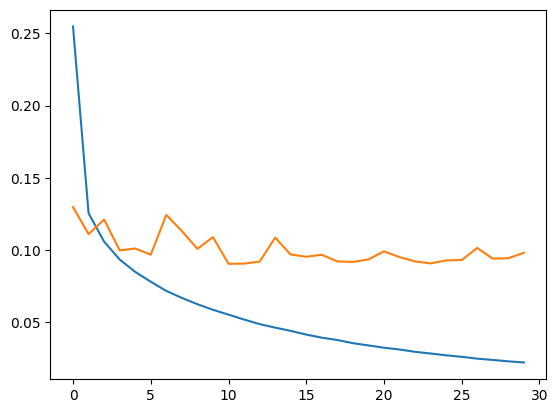

In [12]:
hist_loss = np.array([hist.history['loss'] for hist in history]).reshape((-1,))
hist_vals = np.array([hist.history['val_loss'] for hist in history]).reshape((-1,))
plt.plot(range(len(hist_loss)), hist_loss)
plt.plot(range(len(hist_vals)), hist_vals)

In [13]:
min(history[-1].history['mean_absolute_error']) * y_std

7.76854396108615

In [14]:
model.evaluate({
        'board': test_x1,
        'side': test_x2,
    }, test_y)

1227/1227 [==============================] - 3s 2ms/step - loss: 0.0976 - mean_absolute_error: 0.2013


[0.0975816622376442, 0.2013138085603714]